# Feature: Intersections Weighted by Word Match 

Question intersections weighted by word match ratio (based on the [kernel by @skihikingkevin](https://www.kaggle.com/skihikingkevin/magic-feature-v2-krzy-new-idea)).

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
from collections import defaultdict

In [3]:
import seaborn as sns

In [4]:
import nltk

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yuriyguts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Config

Automatically discover the paths to various data folders and compose the project structure.

In [6]:
project = kg.Project.discover()

Identifier for storing these features on disk and referring to them later.

In [7]:
feature_list_id = 'wm_intersect'

## Load Data

Original question datasets.

In [8]:
df_train = pd.read_csv(project.data_dir + 'train.csv').fillna('none')
df_test = pd.read_csv(project.data_dir + 'test.csv').fillna('none')

## Build features

In [9]:
df_all_pairs = pd.concat([
    df_train[['question1', 'question2']],
    df_test[['question1', 'question2']]
], axis=0).reset_index(drop='index')

In [10]:
stops = set(nltk.corpus.stopwords.words('english'))

In [11]:
def word_match_share(pair):
    q1 = str(pair[0]).lower().split()
    q2 = str(pair[1]).lower().split()
    q1words = {}
    q2words = {}
    
    for word in q1:
        if word not in stops:
            q1words[word] = 1
    for word in q2:
        if word not in stops:
            q2words[word] = 1
    
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2)) / (len(q1words) + len(q2words))

    return R

In [12]:
wms = kg.jobs.map_batch_parallel(
    df_all_pairs[['question1', 'question2']].as_matrix(),
    item_mapper=word_match_share,
    batch_size=1000,
)

Batches: 100%|██████████| 2751/2751 [00:03<00:00, 830.27it/s]


In [13]:
q_dict = defaultdict(dict)
for i in progressbar(range(len(wms))):
    q_dict[df_all_pairs.question1[i]][df_all_pairs.question2[i]] = wms[i]
    q_dict[df_all_pairs.question2[i]][df_all_pairs.question1[i]] = wms[i]

100%|██████████| 2750086/2750086 [03:06<00:00, 14750.65it/s]


In [14]:
def q1_q2_intersect(row):
    return len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']])))

In [15]:
def q1_q2_wm_ratio(row):
    q1 = q_dict[row['question1']]
    q2 = q_dict[row['question2']]
    
    inter_keys = set(q1.keys()).intersection(set(q2.keys()))
    if len(inter_keys) == 0:
        return 0
    
    inter_wm = 0
    total_wm = 0
    
    for q, wm in q1.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    
    for q, wm in q2.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    
    if total_wm == 0:
        return 0
    
    return inter_wm / total_wm

In [16]:
df_train['q1_q2_wm_ratio'] = df_train.apply(q1_q2_wm_ratio, axis=1, raw=True)
df_test['q1_q2_wm_ratio'] = df_test.apply(q1_q2_wm_ratio, axis=1, raw=True)

In [17]:
df_train['q1_q2_intersect'] = df_train.apply(q1_q2_intersect, axis=1, raw=True)
df_test['q1_q2_intersect'] = df_test.apply(q1_q2_intersect, axis=1, raw=True)

## Visualize

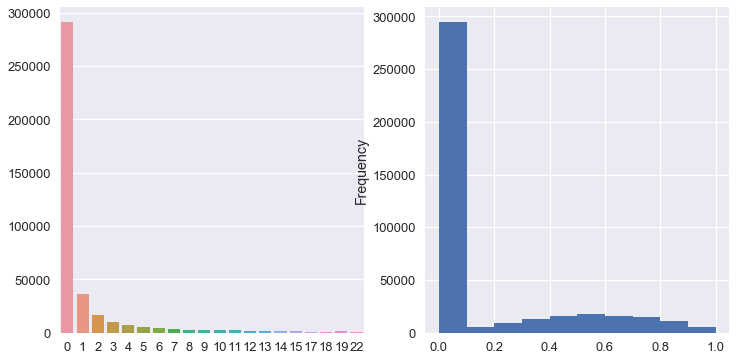

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
intersect_counts = df_train.q1_q2_intersect.value_counts()
sns.barplot(intersect_counts.index[:20], intersect_counts.values[:20])

plt.subplot(1, 2, 2)
df_train['q1_q2_wm_ratio'].plot.hist()

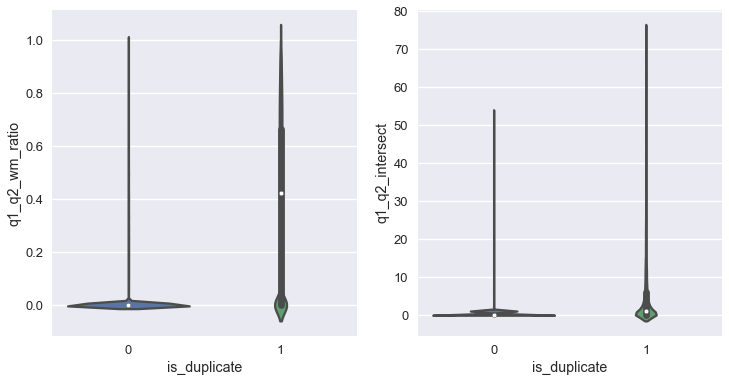

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='q1_q2_wm_ratio', data=df_train)

plt.subplot(1, 2, 2)
sns.violinplot(x='is_duplicate', y='q1_q2_intersect', data=df_train)

                 q1_q2_intersect  q1_q2_wm_ratio
q1_q2_intersect         1.000000        0.684574
q1_q2_wm_ratio          0.684574        1.000000


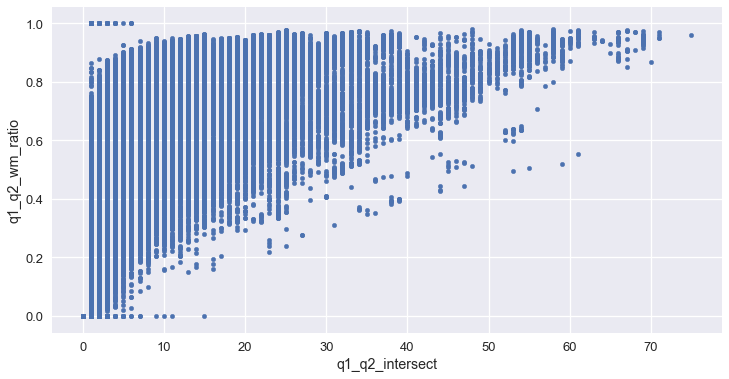

In [20]:
df_train.plot.scatter(x='q1_q2_intersect', y='q1_q2_wm_ratio', figsize=(12, 6))
print(df_train[['q1_q2_intersect', 'q1_q2_wm_ratio']].corr())

## Build final features

In [21]:
columns_to_keep = [
    'q1_q2_intersect',
    'q1_q2_wm_ratio',
]

In [22]:
X_train = df_train[columns_to_keep].values
X_test = df_test[columns_to_keep].values

## Save features

In [23]:
feature_names = columns_to_keep

In [24]:
project.save_features(X_train, X_test, feature_names, feature_list_id)